# Downloading dataset

In [1]:
# install kaggle python api
!pip install kaggle --upgrade

In [2]:
import os, json, subprocess

In [3]:
def check_dataset(path=''):
    if not path:
        path = os.getcwd() + '/dataset/'  
    return os.path.exists(path + 'cataract') and os.path.exists(path + 'diabetic_retinopathy') and os.path.exists(path + 'glaucoma') and os.path.exists(path + 'normal')
    
def init_on_kaggle(username, api_key):
    KAGGLE_CONFIG_DIR = os.path.join(os.path.expandvars('$HOME'), '.kaggle')
    os.makedirs(KAGGLE_CONFIG_DIR, exist_ok = True)
    api_dict = {"username":username, "key":api_key}
    with open(f"{KAGGLE_CONFIG_DIR}/kaggle.json", "w", encoding='utf-8') as f:
        json.dump(api_dict, f)
    cmd = f"chmod 600 {KAGGLE_CONFIG_DIR}/kaggle.json"
    output = subprocess.check_output(cmd.split(" "))
    output = output.decode(encoding='UTF-8')
    print(output)
    
    
def download_dataset_from_kaggle():
    init_on_kaggle("yudzhao", '14e199e96baf549cf5fbf0c5f2dfbc27')
    
    import kaggle
    dataset_name = "gunavenkatdoddi/eye-diseases-classification"
    print(kaggle.api.dataset_view(dataset_name))
    
    kaggle.api.dataset_download_files(dataset_name)
    
    os.system('unzip eye-diseases-classification.zip')
    

In [4]:
dataset_location = os.getcwd() + "/dataset/"

In [5]:
if not check_dataset(dataset_location):
    print('The dataset doesn\'t exist. Try to load from kaggle')
    download_dataset_from_kaggle()

In [6]:
!ls

dataset				   eye-diseases-classification.zip
eye_diseases_classification.ipynb  README.md


# Data Preparation

## Import Images

In [7]:
!pip install Pillow

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,when,length,sum,avg,max,count,round
import seaborn as sns
from PIL import Image, ImageOps, ImageFilter
import io

In [9]:
spark = SparkSession.builder\
        .master("local")\
        .appName("eye_diseases_calssification")\
        .config("spark.driver.memory", "16g") \
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [10]:
df = spark.read.format('image').option('dropInvalid', True).option("recursiveFileLookup","true").load(dataset_location)

In [11]:
df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [12]:
first_img = df.first()['image']
img = Image.frombytes('RGB', (first_img['width'], first_img['height']), bytes(first_img['data']))
img.show()

In [13]:
df.select('image.origin', 'image.width', 'image.height', 'image.nChannels', 'image.mode').show(10, truncate=False)

+------------------------------------------------------------------+-----+------+---------+----+
|origin                                                            |width|height|nChannels|mode|
+------------------------------------------------------------------+-----+------+---------+----+
|file:///home/jovyan/work/BAN5600/dataset/cataract/cataract_024.png|2464 |1632  |3        |16  |
|file:///home/jovyan/work/BAN5600/dataset/glaucoma/Glaucoma_081.png|2464 |1632  |3        |16  |
|file:///home/jovyan/work/BAN5600/dataset/glaucoma/Glaucoma_072.png|2464 |1632  |3        |16  |
|file:///home/jovyan/work/BAN5600/dataset/glaucoma/Glaucoma_024.png|2464 |1632  |3        |16  |
|file:///home/jovyan/work/BAN5600/dataset/glaucoma/Glaucoma_071.png|2464 |1632  |3        |16  |
|file:///home/jovyan/work/BAN5600/dataset/glaucoma/Glaucoma_082.png|2464 |1632  |3        |16  |
|file:///home/jovyan/work/BAN5600/dataset/glaucoma/Glaucoma_048.png|2464 |1632  |3        |16  |
|file:///home/jovyan/work/BAN5

In [14]:
label = when(col('image.origin').contains('cataract'), 'cataract')\
.when(col('image.origin').contains('diabetic_retinopathy'), 'diabetic_retinopathy')\
.when(col('image.origin').contains('glaucoma'), 'glaucoma')\
.otherwise('normal')

df = df.withColumn('type', label)

In [15]:
df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- type: string (nullable = false)



In [16]:
df.show(1, vertical=True)

-RECORD 0---------------------
 image | {file:///home/jov... 
 type  | cataract             
only showing top 1 row



<AxesSubplot: xlabel='type', ylabel='count'>

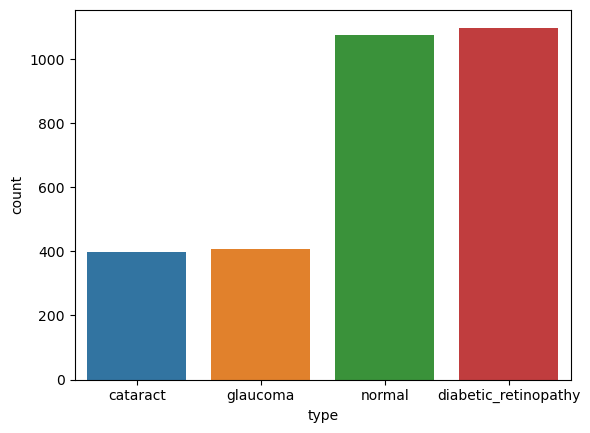

In [17]:
sns.countplot(x=df.select('type').toPandas()['type'])

In [18]:
agg = df.groupby('type').agg( \
    count('type').alias('file_count'), \
    round(avg('image.height'),1).alias('avg_height'), \
    round(avg('image.width'),1).alias('avg_width'), \
    max(length('image.data')).alias('max_file_size'), \
    round(avg(length('image.data')),1).alias('average_file_size')).collect()

In [19]:
agg_df = spark.createDataFrame(agg)

In [20]:
agg_df.show()

+--------------------+----------+----------+---------+-------------+-----------------+
|                type|file_count|avg_height|avg_width|max_file_size|average_file_size|
+--------------------+----------+----------+---------+-------------+-----------------+
|            cataract|       398|     806.6|   1019.2|     13436928|        3815838.4|
|            glaucoma|       407|     802.4|   1012.1|     13436928|        3769809.6|
|              normal|      1074|     512.0|    512.0|       786432|         786432.0|
|diabetic_retinopathy|      1098|     512.0|    512.0|       786432|         786432.0|
+--------------------+----------+----------+---------+-------------+-----------------+



## Feature Extraction

In [117]:
from pyspark.sql.functions import udf, lit
from pyspark.sql.types import BinaryType, ArrayType, IntegerType
import numpy as np
from pyspark.ml.linalg import Vectors, VectorUDT

### Grayscale

In [134]:
def to_grayscale(image):
    img_obj = Image.frombytes('RGB', (image['width'], image['height']), bytes(image['data']))
    img_obj = ImageOps.grayscale(img_obj)
   # imgByteArr = io.BytesIO()
   # img_obj.save(imgByteArr, format=image.format)
    return bytearray(img_obj.tobytes())

In [135]:
type(bytearray(img.tobytes()))

bytearray

In [136]:
grayscale_udf = udf(lambda x:to_grayscale(x), BinaryType())

In [137]:
gray_df = df.withColumn("gray", grayscale_udf(df.image))

### Edge

In [140]:
# def find_edge(image):
#     img_obj = Image.frombytes('RGB', (image['width'], image['height']), bytes(image['data']))
#     img_obj =  img_obj.convert("L").filter(ImageFilter.FIND_EDGES).tobytes()
#     return bytearray(img_obj)


In [141]:
# edge_udf = udf(lambda x:find_edge(x), ArrayType(IntegerType()))

In [142]:
# edge_df = df.withColumn("edge", edge_udf(df.image))

compare orign image, gray image, and edge image

In [143]:
img.show()

In [150]:
first_ = gray_df.first()

In [152]:
Image.frombytes('L', (first_['image']['width'], first_['image']['height']), bytes(first_['gray'])).show()